In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller

# Cointegration and Correlation Analysis

In [3]:
# Function to fetch stock data using yfinance
def fetch_stock_data(ticker, start_date, end_date):
    stock_data = yf.download(ticker, start=start_date, end=end_date, auto_adjust=True)
    # return (stock_data['Close'].pct_change().dropna() + 1).cumprod() - 1
    return stock_data['Close']

# Define the fixed stock and a list of different stocks to pair with
fixed_stock = '1876.HK'
stocks_to_pair = [
    '0291.HK', 
    '0168.HK',  
    # '9633.HK', 
    # '2460.HK'
]  # Add more stocks as needed
name_mapping = {
    '1876.HK': 'Budweiser APAC',
    '0291.HK': 'CR Beer',
    '0168.HK': 'Qing Dao Beer',
    # '9633.HK': 'Nong Fu Shan Quan',
    # '2460.HK': 'CR Drinks'
}

[*********************100%***********************]  3 of 3 completed


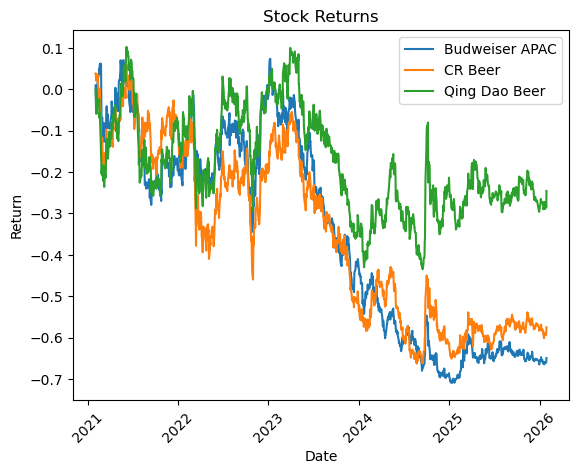

In [4]:
# Fetch historical stock price data and perform analysis for each pair
results = []
start_date = "2021-02-01"
end_date = "2026-01-30"
price_data = fetch_stock_data([fixed_stock]+stocks_to_pair, start_date, end_date)
price_data = price_data.fillna(method='ffill').dropna()
returns = (price_data.pct_change().dropna() + 1).cumprod() - 1
fixed_stock_data = returns[fixed_stock]
plt.plot(fixed_stock_data, label=name_mapping[fixed_stock])
for stock in stocks_to_pair:
    paired_stock_data = returns[stock]

    # cointegration_test = coint(fixed_stock_data, paired_stock_data)
    # cointegration_p_value = cointegration_test[1]

    # Step 1: Regression of paired stock on fixed stock
    X = sm.add_constant(fixed_stock_data)
    model = sm.OLS(paired_stock_data, X).fit()
    residuals = model.resid

    # Step 2: Test residuals for stationarity
    adf_test = sm.tsa.adfuller(residuals)
    adf_p_value = adf_test[1]

    correlation = fixed_stock_data.corr(paired_stock_data)

    results.append({
        'Fixed Stock': name_mapping[fixed_stock],
        'Paired Stock': name_mapping[stock],
        'Cointegration p-value': adf_p_value,
        'Correlation': correlation,
    })

    plt.plot(paired_stock_data, label=name_mapping[stock])

# Create a DataFrame to present the results
results_df = pd.DataFrame(results)

plt.title('Stock Returns')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Return')
plt.legend()
plt.show()

In [5]:
results_df

,Fixed Stock,Paired Stock,Cointegration p-value,Correlation
0,Budweiser APAC,CR Beer,0.007521,0.950845
1,Budweiser APAC,Qing Dao Beer,0.000544,0.819736


# Backtest the Strategy

## Choose Pair Stock and Set Lot Size (for HK stocks)

In [6]:
stock1_data = price_data[fixed_stock]
stock2_data = price_data["0291.HK"]
stock1_lot = 100
stock2_lot = 500

In [7]:
# Scale the data based on shares per hand
stock1_data *= stock1_lot
stock2_data *= stock2_lot

# Calculate the spread between the two stocks
spread = stock1_data - stock2_data

# Perform Augmented Dickey-Fuller (ADF) test to analyze mean-reverting tendencies
adf_test = adfuller(spread.dropna(), maxlag=1)
adf_statistic = adf_test[0]
adf_p_value = adf_test[1]

# Display ADF test results
print("ADF Statistic:", adf_statistic)
print("ADF p-value:", adf_p_value)

ADF Statistic: -1.8366742941225493
ADF p-value: 0.36241185599023884


### Tunable Parameters

In [ ]:
# Risk params: leverage and maintenance margin for margin call
leverage = 2.0
maintenance_margin_pct = 0.3

# Define entry and exit thresholds
entry_threshold = 1.5
exit_threshold = 0.3
stop_loss_pct = 0.02 * leverage

# Define initial capital
initial_capital = 100000

# Z-score parameters
window = 30

### Run Backtest

Stop loss triggered at index 84, date 2021-06-07 00:00:00, trade P/L: -7260.01, current capital: 94759.64
Stop loss triggered at index 93, date 2021-06-21 00:00:00, trade P/L: -4990.01, current capital: 89627.81
Stop loss triggered at index 214, date 2021-12-14 00:00:00, trade P/L: -5656.44, current capital: 107525.70
Stop loss triggered at index 232, date 2022-01-10 00:00:00, trade P/L: -4840.54, current capital: 102502.86
Stop loss triggered at index 429, date 2022-10-28 00:00:00, trade P/L: -10383.56, current capital: 114233.50
Stop loss triggered at index 578, date 2023-06-09 00:00:00, trade P/L: -5447.03, current capital: 130359.66
Stop loss triggered at index 672, date 2023-10-27 00:00:00, trade P/L: -6652.19, current capital: 151290.34
Stop loss triggered at index 688, date 2023-11-20 00:00:00, trade P/L: -6758.13, current capital: 144195.04
Stop loss triggered at index 708, date 2023-12-18 00:00:00, trade P/L: -6910.31, current capital: 137001.83
Stop loss triggered at index 83

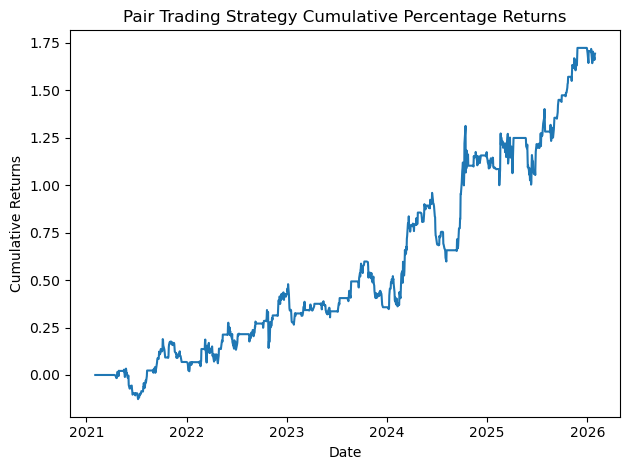

In [ ]:
# Calculate the price ratio between the two stocks
price_ratio = stock1_data / stock2_data

# Calculate z-score of the spread based on a rolling 3-month window
spread_mean = spread.rolling(window=window).mean()
spread_std = spread.rolling(window=window).std()
z_score = (spread - spread_mean) / spread_std

current_capital = initial_capital

# Generate signals
signals = np.where(z_score > entry_threshold, -1, np.where(z_score < -entry_threshold, 1, 0))

# Backtest the pair trading strategy
position = 0
pr = price_ratio.iloc[0]
pct_returns = []
completed_trades = 0
margin_call_count = 0
t = 0
a , b = 0, 0
current_trade_pl = 0
multiple = 0

# Trade logging
trades_log = []
entry_info = None

for i in range(1, len(signals)):
    cost = 0
    old_position = position

    # Compute daily realized P/L based on previous position
    if old_position == 1:
        r = multiple *(a * (stock1_data.iloc[i] - stock1_data.iloc[i-1]) - b * (stock2_data.iloc[i] - stock2_data.iloc[i-1]))
    elif old_position == -1:
        r = multiple * (b * (stock2_data.iloc[i] - stock2_data.iloc[i-1]) - a * (stock1_data.iloc[i] - stock1_data.iloc[i-1]))
    else:
        r = 0

    # Entry signals
    if signals[i] == 1 and position == 0:
        position = 1
        pr = price_ratio.iloc[i]
    elif signals[i] == -1 and position == 0:
        position = -1
        pr = price_ratio.iloc[i]

    # Exit / stop loss
    elif current_trade_pl / current_capital <= -stop_loss_pct or (signals[i] == 0 and abs(z_score.iloc[i]) < exit_threshold and position != 0):
        if current_trade_pl / current_capital <= -stop_loss_pct:
            print(f"Stop loss triggered at index {i}, date {stock1_data.index[i]}, trade P/L: {current_trade_pl:.2f}, current capital: {current_capital:.2f}")
        # log exit if trade was open
        if entry_info is not None:
            entry_info.update({
                'exit_index': i,
                'exit_date': stock1_data.index[i],
                'exit_price_ratio': price_ratio.iloc[i],
                'pnl': current_trade_pl,
                'pnl_pct_of_initial': current_trade_pl / initial_capital if initial_capital != 0 else np.nan
            })
            trades_log.append(entry_info)
        # Exit the position
        position = 0
        completed_trades += 1
        current_trade_pl = 0
        multiple = 0
        entry_info = None

    # On entry, compute integer multiple using leverage and record entry info
    if old_position == 0 and position != 0:
        if pr < 1:
            a = round(1 / pr)
            b = 1
        else:
            a = 1
            b = round(pr)
        t = i
        cost_per_unit = (a * stock1_data.iloc[i] + b * stock2_data.iloc[i])
        # Allow notional up to current_capital * leverage
        if cost_per_unit > 0:
            multiple = int((current_capital * leverage) // cost_per_unit)
        else:
            multiple = 0
        # commission/entry cost (kept as before)
        cost = - multiple * cost_per_unit * 0.1105/100
        # record entry
        entry_info = {
            'entry_index': i,
            'entry_date': stock1_data.index[i],
            'position': position,
            'a': a,
            'b': b,
            'multiple': multiple,
            'entry_capital': current_capital,
            'entry_cost': cost
        }

    current_trade_pl += r
    pct_returns.append((r + cost) / current_capital if current_capital != 0 else 0)
    current_capital += r + cost

    # Margin check while position is open: compute gross position market value
    if position != 0 and multiple > 0:
        pos_market_value = multiple * (abs(a * stock1_data.iloc[i]) + abs(b * stock2_data.iloc[i]))
        # Avoid division by zero
        if pos_market_value > 0:
            margin_ratio = current_capital / pos_market_value
        else:
            margin_ratio = np.inf
        # Trigger margin call (forced liquidation) if maintenance margin breached
        if margin_ratio < maintenance_margin_pct:
            print(f"Margin call triggered at index {i}, date {stock1_data.index[i]}, margin_ratio={margin_ratio:.4f}, capital={current_capital:.2f}")
            # log exit due to margin call
            if entry_info is not None:
                entry_info.update({
                    'exit_index': i,
                    'exit_date': stock1_data.index[i],
                    'pnl': current_trade_pl,
                    'exit_reason': 'margin_call'
                })
                trades_log.append(entry_info)
            # force exit: realize liquidation (already included in r), then reset position
            position = 0
            completed_trades += 1
            margin_call_count += 1
            current_trade_pl = 0
            multiple = 0
            entry_info = None

# End loop
print(f"Completed trades: {completed_trades}")
print(f"Margin calls: {margin_call_count}")
print(f"Total return: {(current_capital - initial_capital) / initial_capital:.2%}")
print(f"Annualized return: {((current_capital / initial_capital) ** (252 / len(pct_returns)) - 1) * 100:.2f}%")

# Calculate cumulative returns
cumulative_pct_returns = np.cumprod(1 + np.array(pct_returns)) - 1 if len(pct_returns) > 0 else np.array([])
fig, ax = plt.subplots(1, 1)
ax.plot(stock1_data.index[1:1+len(cumulative_pct_returns)], cumulative_pct_returns)
ax.set_title('Pair Trading Strategy Cumulative Percentage Returns')
ax.set_xlabel('Date')
ax.set_ylabel('Cumulative Returns')

# --- Sharpe ratio calculation (annualized) ---
daily_returns = np.array(pct_returns)
mean_daily = np.nanmean(daily_returns) if len(daily_returns) > 0 else 0.0
std_daily = np.nanstd(daily_returns) if len(daily_returns) > 0 else 0.0
annual_factor = 252
if std_daily == 0 or np.isnan(std_daily):
    sharpe_ratio = np.nan
else:
    sharpe_ratio = (mean_daily / std_daily) * np.sqrt(annual_factor)
print(f"Sharpe Ratio (annualized): {sharpe_ratio:.4f}")

plt.tight_layout()
plt.show()
# Implement risk management and further refine the strategy as needed

In [12]:
# Save/print trade log
trades_df = pd.DataFrame(trades_log)
if not trades_df.empty:
    display(trades_df)
    # optional: save to CSV
    # trades_df.to_csv('trade_log.csv', index=False)

,entry_index,entry_date,position,a,b,multiple,entry_capital,entry_cost,exit_index,exit_date,exit_price_ratio,pnl,pnl_pct_of_initial
0,47,2021-04-14,1,13,1,3,100000.000000,-186.754480,59,2021-04-30,0.076613,2410.926819,0.024109
1,70,2021-05-17,1,13,1,3,102137.822661,-204.528250,84,2021-06-07,0.070232,-7260.007095,-0.072600
2,85,2021-06-08,1,14,1,2,92940.123672,-141.817619,93,2021-06-21,0.068168,-4990.009689,-0.049900
3,97,2021-06-25,1,15,1,2,90371.644371,-148.416602,100,2021-06-30,0.069178,1000.899506,0.010009
4,101,2021-07-02,-1,14,1,2,90447.524339,-133.315375,113,2021-07-20,0.069224,34.378052,0.000344
5,117,2021-07-26,-1,13,1,3,91477.104929,-184.575001,128,2021-08-10,0.065699,9156.618309,0.091566
6,144,2021-09-01,1,17,1,3,102350.020277,-196.615771,172,2021-10-15,0.064532,14216.123199,0.142161
7,179,2021-10-26,1,17,1,3,109218.280681,-190.768871,214,2021-12-14,0.058973,-5656.439781,-0.056564
8,227,2022-01-03,-1,15,1,3,106843.800567,-182.296231,232,2022-01-10,0.070521,-4840.536690,-0.048405
9,233,2022-01-11,-1,14,1,3,102128.980227,-169.872830,241,2022-01-21,0.067890,3576.646042,0.035766
